In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from dataloader import *
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline

## Model 

In [2]:
class Model(nn.Module):
    def __init__(self,num_layers):
        super(Model,self).__init__()
        self.model1 = nn.ModuleList([nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(1,1,3,bias=False)) for i in range(num_layers)])
        self.model2 = nn.ModuleList([nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(1,1,3,bias=False)) for i in range(num_layers)])
        self.model3 = nn.ModuleList([nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(1,1,3,bias=False)) for i in range(num_layers)])
        self.model4 = nn.ModuleList([nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(1,1,3,bias=False)) for i in range(num_layers)])
#         self.model = nn.Sequential(self.model1)
    def forward(self,x):
#         print(x)
        x1 = reduce(lambda acc, el: el(acc), self.model1, x)
        x2 = reduce(lambda acc, el: el(acc), self.model2, x)
        x3 = reduce(lambda acc, el: el(acc), self.model3, x)
        x4 = reduce(lambda acc, el: el(acc), self.model4, x)
        
        x = torch.cat((x1,x2,x3,x4),1)
        return x

### Dataloader used to get data

In [3]:
num_workers = 1
train_batch_size = 64
val_batch_size = 1
trainData = Ipde('./data/train_data/')
valData = Ipde('./data/val_data/')
# testData = Ipde('./data/test_data/')

# delta X
nx = 64.
delx = 2.*3.14/nx
delt = 0.1

trainDataloader = DataLoader(trainData,num_workers=num_workers,batch_size=train_batch_size)
valDataloader = DataLoader(valData,num_workers=num_workers,batch_size=val_batch_size)
# testDataloader = DataLoader(testData,num_workers,batch_size)

trainIter = iter(trainDataloader)
train = trainIter.next()
valIter = iter(valDataloader)
val = valIter.next()

In [4]:
int(os.path.split(os.path.split(trainData.data[0])[0])[1].zfill(3)+os.path.split(trainData.data[0])[1][:-4].zfill(3))

2001

In [5]:
l = ['file-1', 'file-9', 'file-2', 'file-10']
sorted( l, key=lambda a: int(a.split("-")[1]) )

['file-1', 'file-2', 'file-9', 'file-10']

In [39]:
def psi_input(u):
    filter_1 = np.expand_dims(np.expand_dims(np.array([[0,0,0],[-0.5,0,0.5],[0,0,0]]),0),0)/delx
    filter_2 = np.expand_dims(np.expand_dims(np.array([[0,-0.5,0],[0,0,0],[0,0.5,0]]),0),0)/delx
    filter_3 = np.expand_dims(np.expand_dims(np.array([[0,0,0],[1.,-2.,1.],[0,0,0]]),0),0)/(delx**2)
    filter_4 = np.expand_dims(np.expand_dims(np.array([[0,1.,0],[0,-2.,0],[0,1.,0]]),0),0)/(delx**2)
    Filter_var = np.concatenate([filter_2,filter_1,filter_4,filter_3],axis=0)
    if(torch.cuda.is_available()!=False):
        Filter_var = Variable(torch.FloatTensor(Filter_var).cuda(), requires_grad=False)
    else:
        Filter_var = Variable(torch.FloatTensor(Filter_var), requires_grad=False)
    u = F.pad(u, (1,1,1,1), mode='replicate')
    out = F.conv2d(u, Filter_var, stride=1, padding=0)
    return out

In [18]:
def parameter_mult(psi,parameters):
#     print(psi.shape,parameters.shape)
    out = torch.mul(psi,parameters.unsqueeze(-1).unsqueeze(-1))
    output = out[:,0:1,:,:]+out[:,1:2,:,:]+out[:,2:3,:,:]+out[:,3:4,:,:]
    return output

In [19]:
model = Model(3)

In [20]:
model

Model(
  (model1): ModuleList(
    (0): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (1): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (2): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
  )
  (model2): ModuleList(
    (0): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (1): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (2): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
  )
  (model3): ModuleList(
    (0): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d

In [37]:
def phi_input(u, parameters, delta_t):
    w = parameter_mult(psi_input(u), parameters)*delta_t
    psi = w + u
    # Boundary correction should be here on psi
#     print(model(input_to_net).shape)
    convmodel = torch.sum(parameter_mult(model(w), parameters)*0.5*delta_t, 1, keepdim=True)
    return psi, convmodel + psi

In [22]:
# def valphi_input(u, parameters, delta_t):
#     psi = parameter_mult(psi_input(u),parameters)
#     psi = psi*delta_t
#     input_to_net = psi - u
# #     print(model(input_to_net).shape)
#     convmodel = model.forward(input_to_net)*0.5*delta_t + psi
#     convmodel = convmodel[:,0:1,:,:]+convmodel[:,1:2,:,:]+convmodel[:,2:3,:,:]+convmodel[:,3:4,:,:]
#     return convmodel

In [23]:
# No of parameters in the network
sum(p.numel() for p in model.parameters())

108

### Loss Functions and optimization

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1, betas=(0.9,0.99), weight_decay=0)

CUDA Training


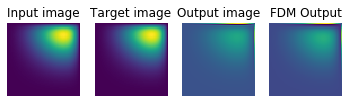

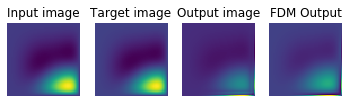

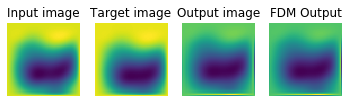

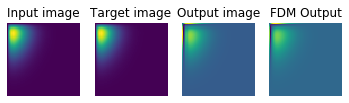

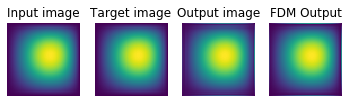

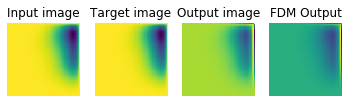

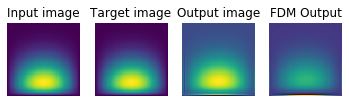

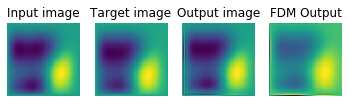

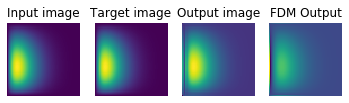

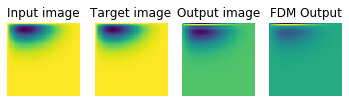

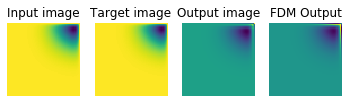

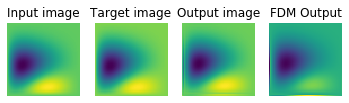

Epoch: 1 	Training Loss: 0.000028


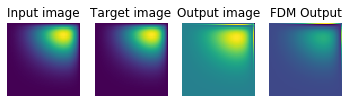

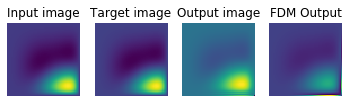

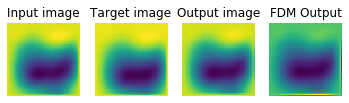

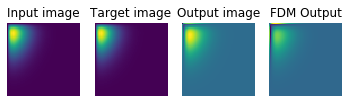

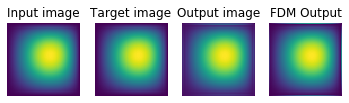

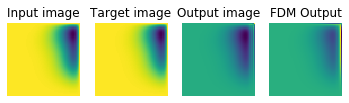

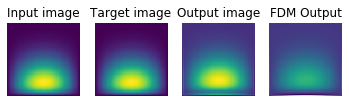

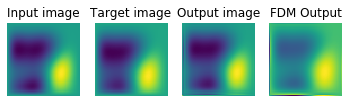

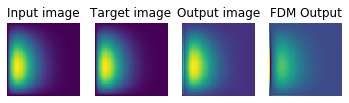

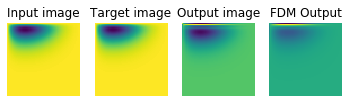

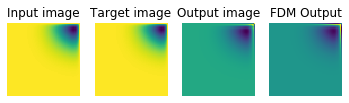

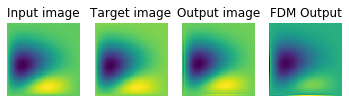

Epoch: 2 	Training Loss: 0.000022


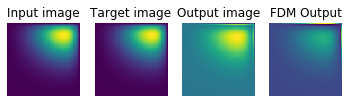

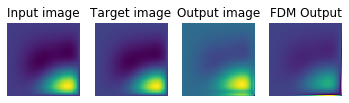

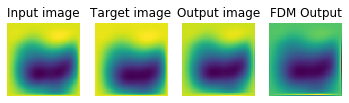

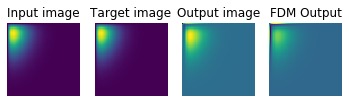

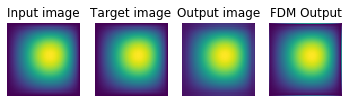

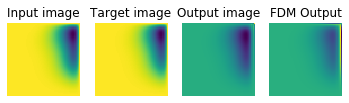

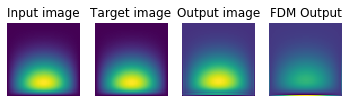

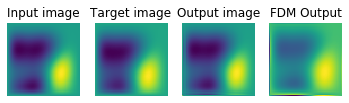

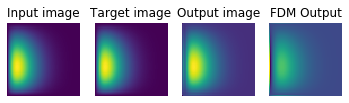

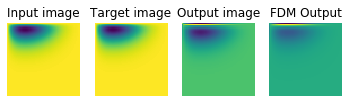

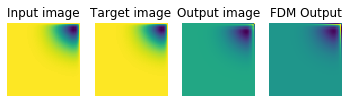

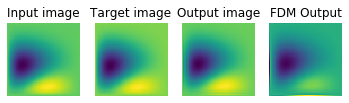

Epoch: 3 	Training Loss: 0.000017


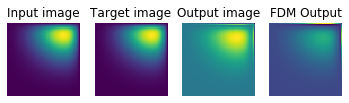

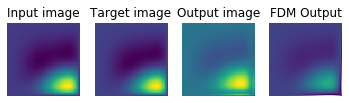

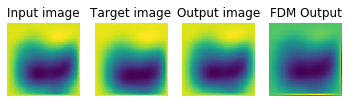

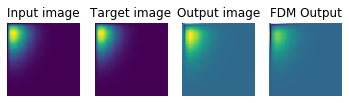

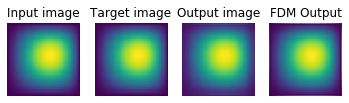

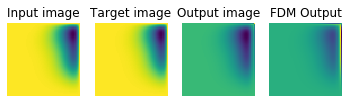

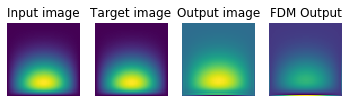

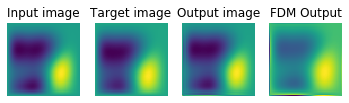

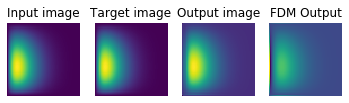

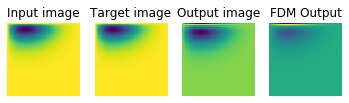

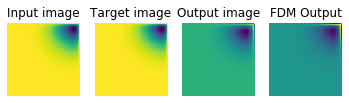

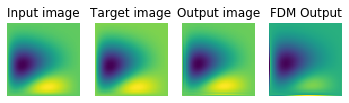

Epoch: 4 	Training Loss: 0.000017


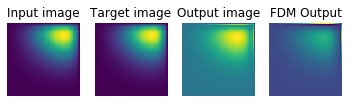

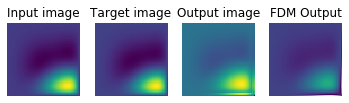

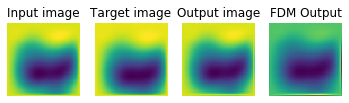

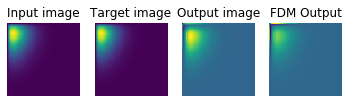

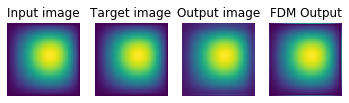

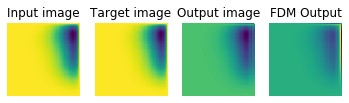

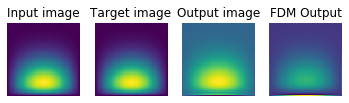

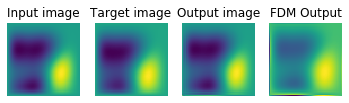

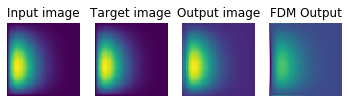

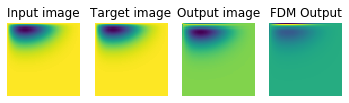

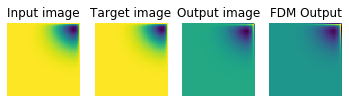

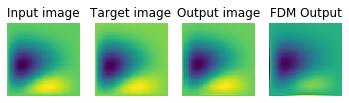

Epoch: 5 	Training Loss: 0.000018


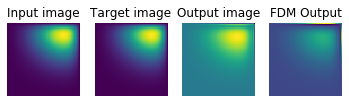

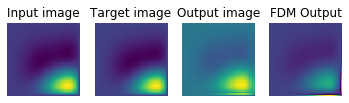

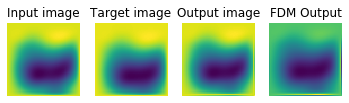

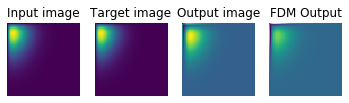

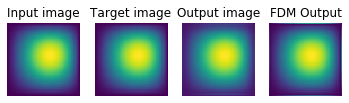

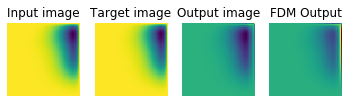

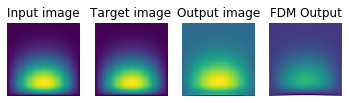

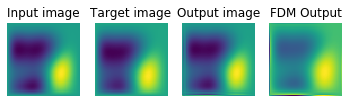

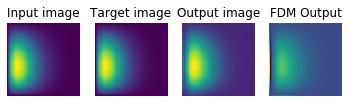

KeyboardInterrupt: 

In [25]:
num_epochs = 20
if (torch.cuda.is_available()==1):
    print('CUDA Training')
    model.cuda()

model.train()
for epoch in range(1,num_epochs+1):
    train_loss = 0.0
    i = 0
    for parameter,data,target in trainDataloader:
    
        if(torch.cuda.is_available()):
            data = data.type(torch.FloatTensor).cuda()
            parameter = parameter.type(torch.FloatTensor).cuda()
            target = target.type(torch.FloatTensor).cuda()
        else:
            data = data.type(torch.FloatTensor)
            parameter = parameter.type(torch.FloatTensor)
            target = target.type(torch.FloatTensor)
        
        optimizer.zero_grad()
        FDM_out, output = phi_input(data, parameter, 0.1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        i += 1
        if i%10==0:
            data = data.cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            output = output.cpu().detach().numpy()
            FDM_out = FDM_out.cpu().detach().numpy()
            output_image = output[0,:,:,:].squeeze(0)
            FDM_out = FDM_out[0,:,:,:].squeeze(0)
            input_image = data[0,:,:,:].squeeze(0)
            target_image = target[0,:,:,:].squeeze(0)
            plt.subplot(1,4,1)
            plt.title('Input image')
            plt.axis('off')
            plt.imshow(input_image)
            plt.subplot(1,4,2)
            plt.title('Target image')
            plt.axis('off')
            plt.imshow(target_image)
            plt.subplot(1,4,3)
            plt.title('Output image')
            plt.axis('off')
            plt.imshow(output_image)
            plt.subplot(1,4,4)
            plt.title('FDM Output')
            plt.axis('off')
            plt.imshow(FDM_out)
            plt.show()
        
    train_loss = train_loss/len(trainDataloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [ ]:
model.eval()
for epoch in range(1,num_epochs+1):
    val_loss = 0.0
    fdm_loss = 0.0
    for parameter,data,target in valDataloader:
        if(torch.cuda.is_available()):
            data = data.type(torch.FloatTensor).cuda()
            parameter = parameter.type(torch.FloatTensor).cuda()
            target = target.type(torch.FloatTensor).cuda()
        else:
            data = data.type(torch.FloatTensor)
            parameter = parameter.type(torch.FloatTensor)
            target = target.type(torch.FloatTensor)
        
        FDM_out, output = phi_input(data, parameter, 0.1)
        loss = criterion(output,target)
        val_loss += loss.item()
        loss = criterion(FDM_out,target)
        fdm_loss += loss.item()
#         val_loss.append(loss.data.cpu().numpy())
    val_loss_epoch = val_loss/len(valDataloader)
    fdm_loss_epoch = fdm_loss/len(valDataloader)
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(epoch, val_loss_epoch))
    print('Epoch: {} \tFDM Loss: {:.6f}'.format(epoch, fdm_loss_epoch))

## Plot the losses

In [ ]:
x = np.array(train_loss)
y = np.array(val_loss)

In [ ]:
plt.figure()
plt.plot(x)
plt.plot(y)
plt.show()

In [ ]:
model.eval()
tot_error = 0.0
for parameter,data,target in valDataloader:
    if(torch.cuda.is_available()):
        data = data.type(torch.FloatTensor).cuda()
        parameter = parameter.type(torch.FloatTensor).cuda()
        target = target.type(torch.FloatTensor).cuda()
    else:
        data = data.type(torch.FloatTensor)
        parameter = parameter.type(torch.FloatTensor)
        target = target.type(torch.FloatTensor)
        
    output = phi_input(data,parameter,0.1)
    data = data.cpu().detach().numpy()
    output = output.cpu()
    output = output.detach().numpy()
    output = output.squeeze(0)
    image = plt.imshow(output.squeeze(0))
    input_image = plt.imshow(data.squeeze(0).squeeze(0))
#     plt.subplot(i,2,1)
#     plt.title('Input image')
#     plt.axis('off')
#     plt.imshow(input_image)
#     plt.subplot(i,2,2)
#     plt.title('Output image')
#     plt.axis('off')
#     plt.imshow(image)
    
    error = np.sqrt(np.mean((output - data)**2))
#     print('root mean square error',error)
    tot_error += error
avg_error = tot_error/len(valDataloader)
print(avg_error)

## Save the model

In [ ]:
torch.save(model,'./Model/model.pt')

## Inference

In [26]:
#Load the testdata
num_workers = 1
batch_size = 1
testData = Ipde('./data/test_data/')


testDataloader = DataLoader(trainData,num_workers=num_workers,batch_size=batch_size)

testIter = iter(testDataloader)
test = testIter.next()

In [ ]:
model.eval()
tot_error = 0.0
for parameter,data,target in testDataloader:
    if(torch.cuda.is_available()):
        data = data.type(torch.FloatTensor).cuda()
        parameter = parameter.type(torch.FloatTensor).cuda()
        target = target.type(torch.FloatTensor).cuda()
    else:
        data = data.type(torch.FloatTensor)
        parameter = parameter.type(torch.FloatTensor)
        target = target.type(torch.FloatTensor)
        
    output = phi_input(data,parameter,0.1)
    data = data.cpu().detach().numpy()
    output = output.cpu()
    output = output.detach().numpy()
    output = output.squeeze(0)
    image = output.squeeze(0)
    input_image = data.squeeze(0).squeeze(0) 
    error = np.sqrt(np.mean((output - data)**2))
#     print('root mean square error',error)
    tot_error += error
avg_error = tot_error/len(testDataloader)
print(avg_error)

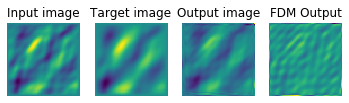

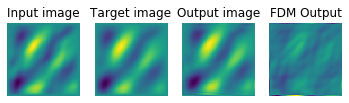

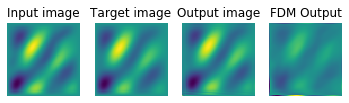

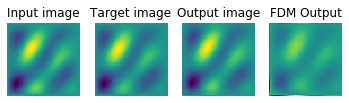

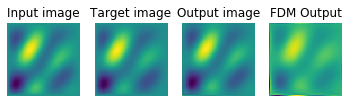

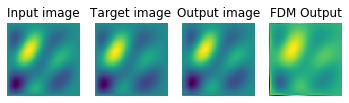

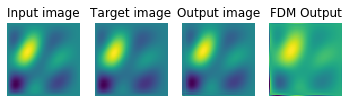

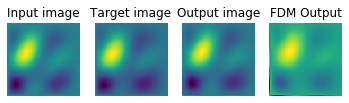

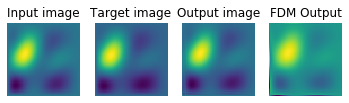

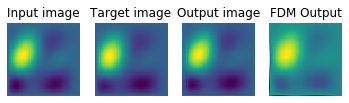

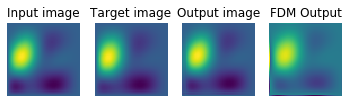

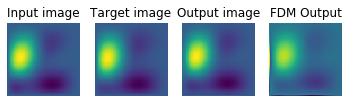

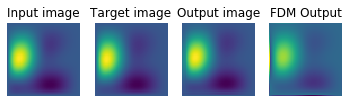

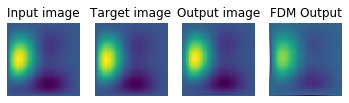

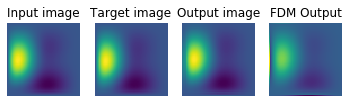

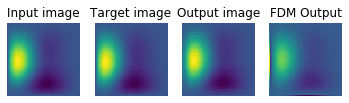

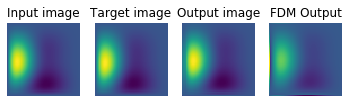

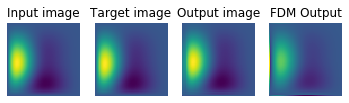

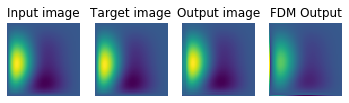

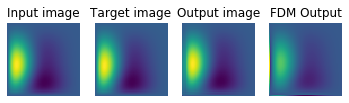

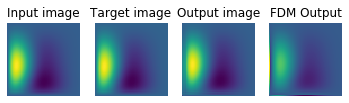

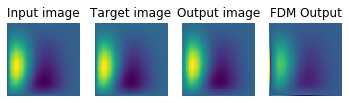

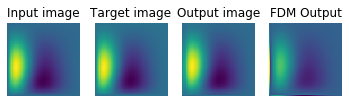

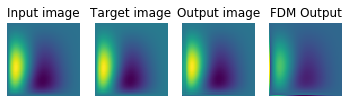

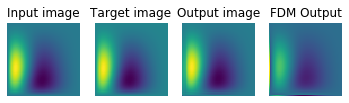

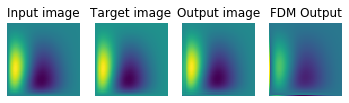

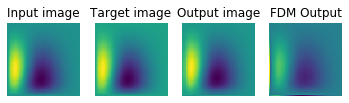

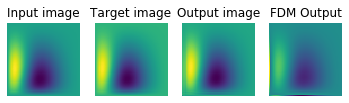

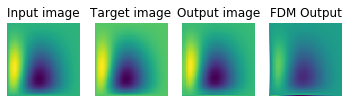

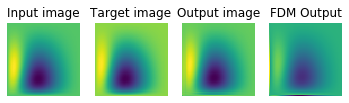

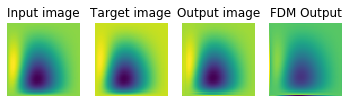

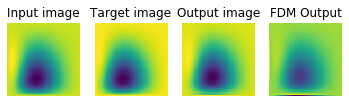

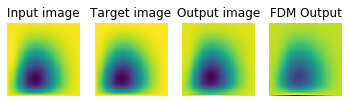

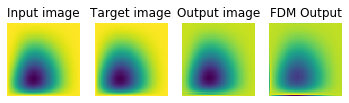

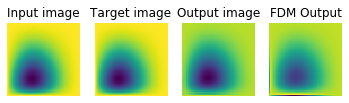

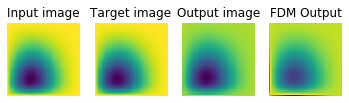

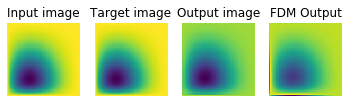

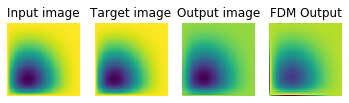

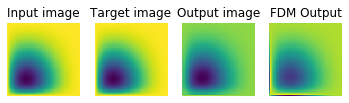

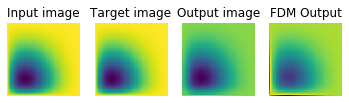

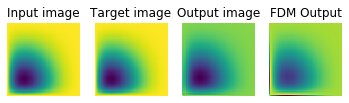

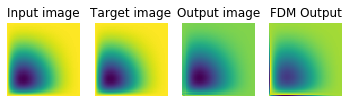

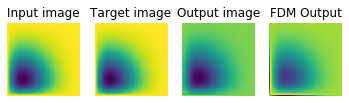

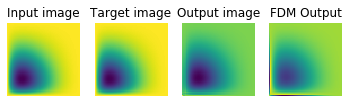

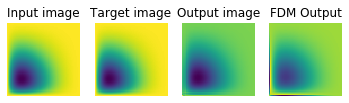

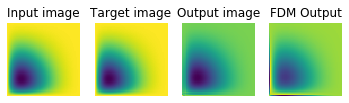

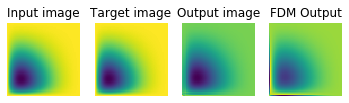

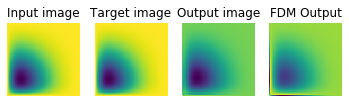

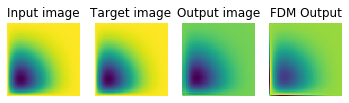

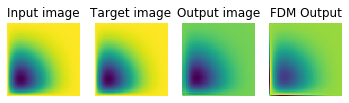

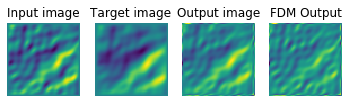

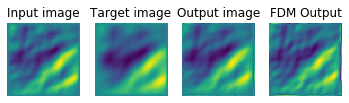

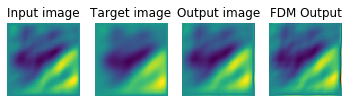

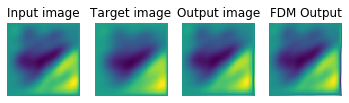

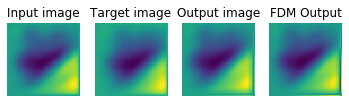

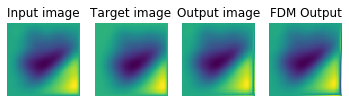

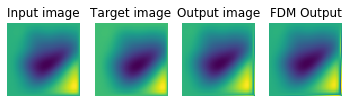

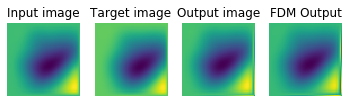

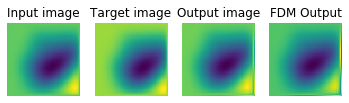

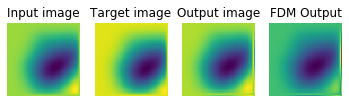

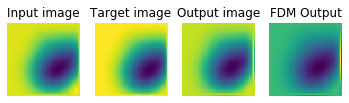

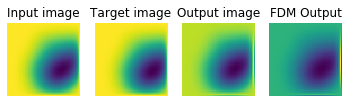

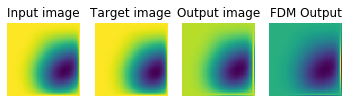

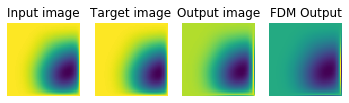

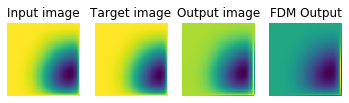

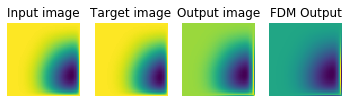

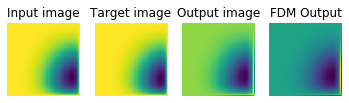

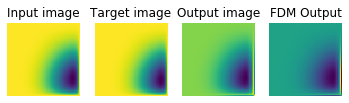

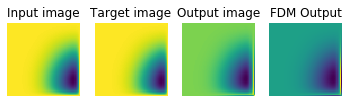

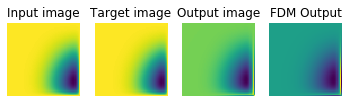

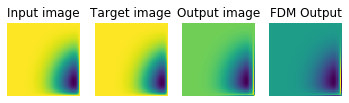

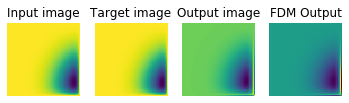

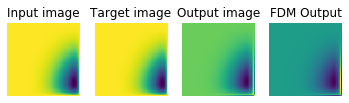

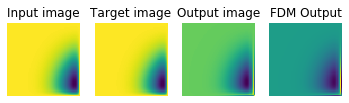

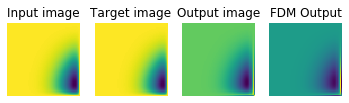

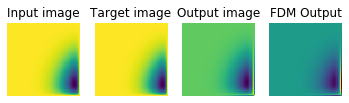

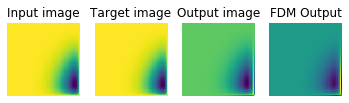

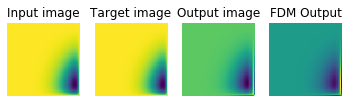

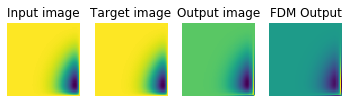

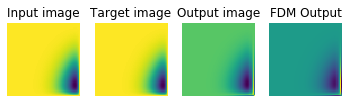

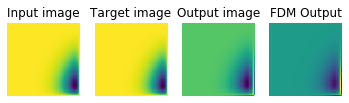

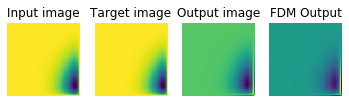

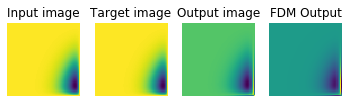

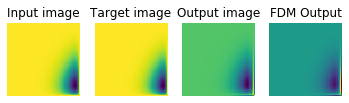

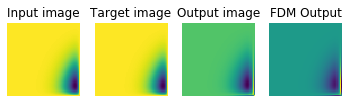

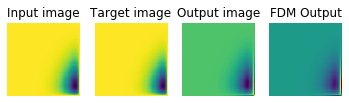

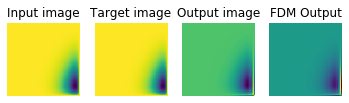

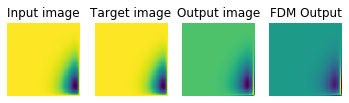

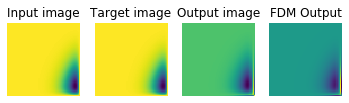

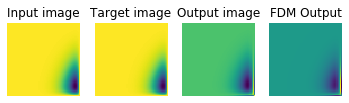

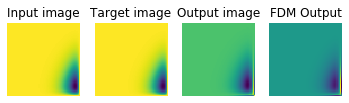

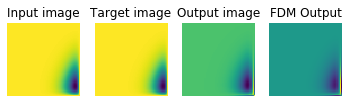

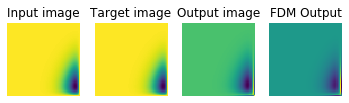

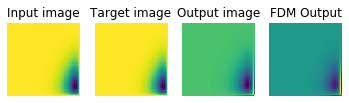

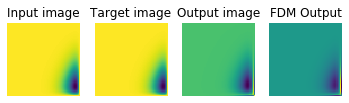

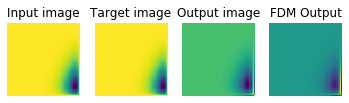

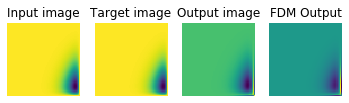

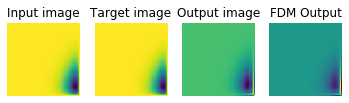

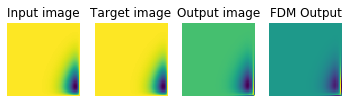

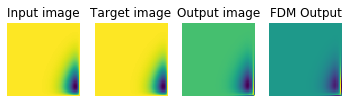

In [38]:
#plot some images
counter = 0
for i,(parameter,data,target) in enumerate(testDataloader):
    if(torch.cuda.is_available()):
        data = data.type(torch.FloatTensor).cuda()
        parameter = parameter.type(torch.FloatTensor).cuda()
        target = target.type(torch.FloatTensor).cuda()
    else:
        data = data.type(torch.FloatTensor)
        parameter = parameter.type(torch.FloatTensor)
        target = target.type(torch.FloatTensor)
        
    FDM_out, output = phi_input(data,parameter,0.1)
    data = data.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    FDM_out = FDM_out.cpu().detach().numpy()
    FDM_out = FDM_out.squeeze(0).squeeze(0)
    output = output.cpu().detach().numpy()
    output_image = output.squeeze(0).squeeze(0)
    input_image = data.squeeze(0).squeeze(0)
    target_image = target.squeeze(0).squeeze(0)
    plt.subplot(1,4,1)
    plt.title('Input image')
    plt.axis('off')
    plt.imshow(input_image)
    plt.subplot(1,4,2)
    plt.title('Target image')
    plt.axis('off')
    plt.imshow(target_image)
    plt.subplot(1,4,3)
    plt.title('Output image')
    plt.axis('off')
    plt.imshow(output_image)
    plt.subplot(1,4,4)
    plt.title('FDM Output')
    plt.axis('off')
    plt.imshow(FDM_out)
    plt.show()
    counter+=1
    if(counter == 100):
        break